# This notebook gives busineess action plans based on customer segments using RFM and Customer Life Time value

**In this notebook we have not only provided business insights for this particular data**

**but also built a generic function to calculate customer life time value**

In [1]:
! pip install lifetimes
! pip install seaborn
! pip install dexplot

In [2]:
!jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import dexplot as dxp

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../input/customer-personality-analysis/marketing_campaign.csv',sep='\t')
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
# df.set_index('ID',inplace=True,drop=True)
# df.index.name = None
df.head(10)

# RFM Customer Segmentation 

**Recency**: Number of days since customer's last purchase

**Monetory Value**: Total monetary value the customer spent on   
Monetory Value = MntWines+ MntFruits+ MntMeatProducts+ MntFishProducts+ MntSweetProducts+ MntGoldProds    

**Frequency** = NumWebPurchases + NumCatalogPurchases + NumStorePurchases



In [6]:
df_RFM = df[['ID','Recency']]
df_RFM['Monetary'] =  df['MntWines']+ df['MntFruits']+ df['MntMeatProducts']+ df['MntFishProducts']+ df['MntSweetProducts']+ df['MntGoldProds']  
df_RFM['Frequency'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

In [7]:
quintiles = df_RFM[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()

In [8]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5  

In [9]:
df_RFM['R'] = df_RFM['Recency'].apply(lambda x: r_score(x))
df_RFM['F'] = df_RFM['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
df_RFM['M'] = df_RFM['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [10]:
df_RFM['RFM Score'] = df_RFM['R'].map(str) + df_RFM['F'].map(str) + df_RFM['M'].map(str)

In [11]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

df_RFM['Segment'] = df_RFM['R'].map(str) + df_RFM['F'].map(str)
df_RFM['Segment'] = df_RFM['Segment'].replace(segt_map, regex=True)
df_RFM.head()

In [12]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(df_RFM['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(df_RFM['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(df_RFM['Monetary'])
# Show the plot
plt.show()

* Segment----------------------------->Description
* Champions-------------------------->Bought recently, buy often and spend the most
* Loyal Customers-------------------->Buy on a regular basis. Responsive to promotions.
* Potential Loyalist------------------->Recent customers with average frequency.
* Recent Customers------------------->Bought most recently, but not often.
* Promising---------------------------->Recent shoppers, but haven’t spent much.
* Customers Needing Attention------>Above average recency, frequency and monetary values. May not have bought very recently though.
* About To Sleep---------------------->Below average recency and frequency. Will lose them if not reactivated.
* At Risk------------------------------->Purchased often but a long time ago. Need to bring them back!
* Can’t Lose Them-------------------->Used to purchase frequently but haven’t returned for a long time.
* Hibernating------------------------->Last purchase was long back and low number of orders. May be lost.

In [13]:
# count the number of customers in each segment
def customerSegmentPlot(df_RFM, title):
    segments_counts = df_RFM.value_counts().sort_values(ascending=True)

    fig, ax = plt.subplots()

    bars = ax.barh(range(len(segments_counts)),
                  segments_counts,
                  color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False,
                   bottom=False,
                   labelbottom=False)
    ax.set_yticks(range(len(segments_counts)))
    ax.set_yticklabels(segments_counts.index)
    ax.set_title(title,fontsize=15)
    for i, bar in enumerate(bars):
            value = bar.get_width()
            if segments_counts.index[i] in ['champions', 'loyal customers']:
                bar.set_color('C1')
            ax.text(value,
                    bar.get_y() + bar.get_height()/2,
                    '{:,} ({:}%)'.format(int(value),
                                       round(value*100/2240,2)),
                    va='center',
                    ha='left'
                   )

    plt.show()
    
customerSegmentPlot(df_RFM['Segment'], title ="Customer category")

In [14]:
df_RFM_score = df.merge(df_RFM.drop(['Recency'],axis=1),how='left',on='ID')
df_RFM_score['NumDealsPurchases_'] =  df_RFM_score['NumDealsPurchases'].mask(df_RFM_score['NumDealsPurchases']>5,5)

# Does discount help business? 

**Yes, it definitely helps. Almost all customers use Discounts, only 2% doesn't use discounts. About 43% are one time discount users.** 

~2% customers use Discount only once

~40% customers use Discount only once

~20% customers use Discount twice

~35% customers use Discount more than twice


In [15]:
sns.histplot(df_RFM_score['NumDealsPurchases_'],stat="probability")

# Are customers who use discount more often (>3) are loyal? 

**Most customers who use discounts often are loyal (50%).**

In [16]:
sns.histplot(df_RFM[df_RFM_score['NumDealsPurchases_']>3],stat="probability", y="Segment")

# Interactive plot to select customer category based on number of purchases

Note: You have to take a copy and run this section for interactive use. 

In [17]:
print("Select Customer number of Discount purchases:")

dropdown = widgets.Dropdown(options = sorted(list(set(df_RFM_score['NumDealsPurchases_']))))

@interact
def line_plot(NumDealsPurchases = sorted(df_RFM_score['NumDealsPurchases_'].unique())):
    
    df_RFM_discount = df_RFM_score[df_RFM_score['NumDealsPurchases_'] == NumDealsPurchases]['Segment']
    
    customerSegmentPlot(df_RFM_discount, title ="Customer categories for "+str(NumDealsPurchases) +" times discount used users"+
                        "  (Customer percentage ="+str(round(len(df_RFM_discount)*100/len(df_RFM_score),2))+" %)")
    
print("Note: All the percentages are calculated w.r.t total, they are not relative to specific category")

# Interactive plot to group customer category based on a specific column

Note: You have to take a copy and run this section for interactive use. 

In [27]:
print("Select Column Name:")

dropdown = widgets.Dropdown(options = sorted(list(set(df_RFM_score.columns))))
col_= df_RFM_score.dtypes==('int64' or 'float64')

@interact
def line_plot(col_name = sorted(col_[col_==True].index)):
    df__= df_RFM_score.groupby(['Segment']).mean().reset_index()
    sns.barplot(x=col_name, y="Segment", data=df__[['Segment',col_name]])
    plt.title("Customer segment w.r.t "+col_name)
    print(col_name)
    plt.show()

# Estimating Customer lifetime Value using Gamma-Gamma Model 

#### **Customer Lifetime value** = (predicted number of transactions in the next quaterly/yearly) * (Expected average sales from that customer)

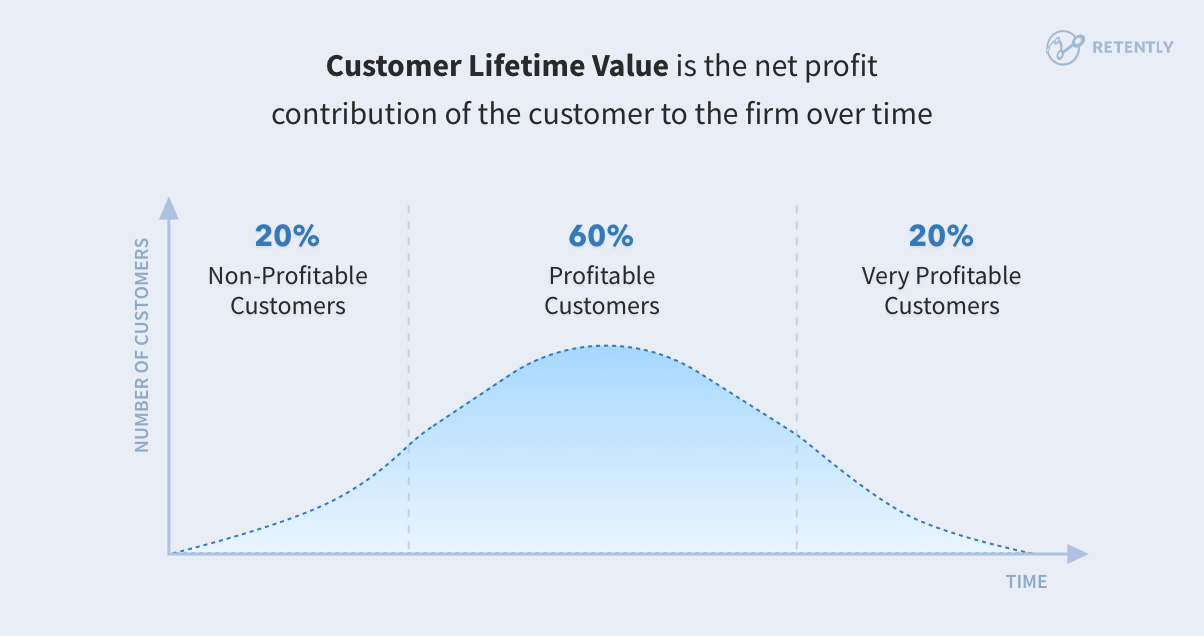


In [19]:
# Calculate the entire transation period of customers
df_RFM_score['T'] = ( df_RFM_score['Dt_Customer'].max()- df_RFM_score['Dt_Customer']).dt.days +90

In [20]:
def CustomerLifeTimeValue(df,penalizer_coef=0.01,months_to_predict=3, discount_rate=0.01):
    '''
    args = df must have Frequency(count), Recency(days), Monetary($) and T (Transation period in days)
    output = [['ID','predicted_clv','manual_predicted_clv']]
    '''

# Discount rate converts future cash flows (that is revenue/profits) into today’s money for the firm
# discount_rate=0.01 ----> monthly discount rate ~ 12.7% annually  
    import lifetimes
    import pandas as pd
    import numpy as np
    #       Filter out customer those who have never visited again 
    df = df[df['Frequency']>=1]
    bgf = lifetimes.BetaGeoFitter(penalizer_coef=penalizer_coef)
    bgf.fit(df['Frequency'], df['Recency'], df['T'])

    # Compute the customer alive probability
    df['probability_alive'] = bgf.conditional_probability_alive(df['Frequency'], df['Recency'], df['T'])

    # Predict future transaction for the next 90 (months_to_predict*30) days based on historical data
    transaction_date = months_to_predict*30
    df['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(transaction_date, 
                                                                                       df['Frequency'],
                                                                                       df['Recency'],
                                                                                       df['T']),2)


    df_repeated_customers = df.copy()
    # Modeling the monetary value using Gamma-Gamma Model from Lifetimes python library 
    ggf = lifetimes.GammaGammaFitter(penalizer_coef=penalizer_coef)
    ggf.fit(df_repeated_customers['Frequency'],
     df_repeated_customers['Monetary'])

    df_repeated_customers['exp_avg_sales'] = ggf.conditional_expected_average_profit(df_repeated_customers['Frequency'],
                                     df_repeated_customers['Monetary'])

    # predicted_clv --> predicted_annual_lifetime_value
    # Predicting Customer Lifetime Value for the next 3 months
    df_repeated_customers['predicted_clv'] = ggf.customer_lifetime_value(bgf,
                                     df_repeated_customers['Frequency'],
                                     df_repeated_customers['Recency'],
                                     df_repeated_customers['T'],
                                     df_repeated_customers['Monetary'],
                                     time=months_to_predict,     # lifetime in months
                                     freq='D',   # frequency in which the data is present(transaction_date)      
                                     discount_rate=discount_rate) # discount rate

    # Manual predict clv = Predicted no. of transactions * Expected avg sales 
    df_repeated_customers['manual_predicted_clv'] = (df_repeated_customers['pred_num_txn'] *
                                                     df_repeated_customers['exp_avg_sales'])

#     if the clv is nan impute with mean
#     df_repeated_customers['predicted_clv'].fillna(df_repeated_customers['predicted_clv'].mean(), inplace=True)
#     df_repeated_customers['manual_predicted_clv'].fillna(df_repeated_customers['manual_predicted_clv'].mean(), inplace=True)
    df_repeated_customers = df_repeated_customers.round(2)

    return df_repeated_customers[['ID','predicted_clv','manual_predicted_clv']]

**Predict Customer lifetime value for the next Quaterly (3 months)**

In [34]:
clv = CustomerLifeTimeValue(df_RFM_score,months_to_predict=3)

**Since Majority of the CLV scores are 0, we are quantile customers into two category**
* Profitable and 
* Non-Profitable

In [35]:
clv['clv_label'] = clv['predicted_clv']>0
clv['clv_label'] = clv['clv_label'].map({True: 'profitable', False: 'Non-profitable'})

# LeftMerge CLV on main df
df_RFM_score = df_RFM_score.merge(clv,how='left', on = 'ID')

# What percentage of Customers drives the profit? 

~ 15% of customers drives profit.

In [36]:
sns.histplot(clv['clv_label'],stat="probability")
plt.title("Percentage of profitable and non profitable customers")

# Interactive plot to groupby Profitable and Non-Profitable Customers based on a specific attribute 
Note: You have to take a copy and run this section for interactive use. 

In [38]:

print("Select Column Name:")

dropdown = widgets.Dropdown(options = sorted(list(set(df_RFM_score.columns))))
col_= df_RFM_score.dtypes==('int64' or 'float64')

@interact
def line_plot(col_name = sorted(col_[col_==True].index)):
    df__= df_RFM_score.groupby(['clv_label']).mean().reset_index()
    sns.barplot(x=col_name, y="clv_label", data=df__[['clv_label',col_name]])
    plt.title("Profitable and Non profitable customers in "+col_name)
    plt.show()



# Business actions from the following analysis: 
* **Look into customer complaints as there are significant complaints from the profitable customers, fix service based complaints and improve quality of service**

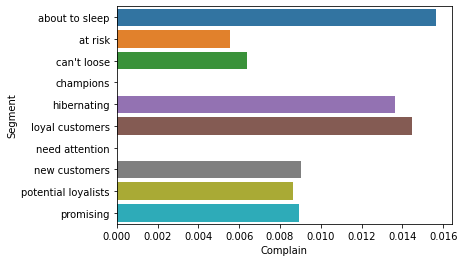

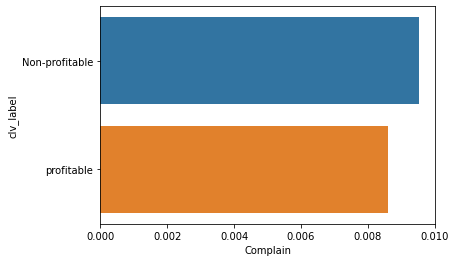
* **Customer aqusition cost should be optimised between online addvertisements and discounts. As profitable customers visit website often. The already existing customer in online are more loyal and consistent.**

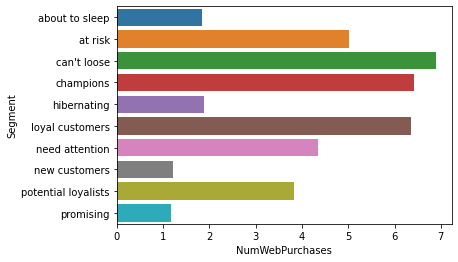

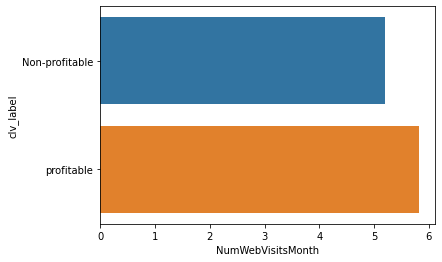
* **Most profitable customers have kids at home, increase targeted add for parents** 

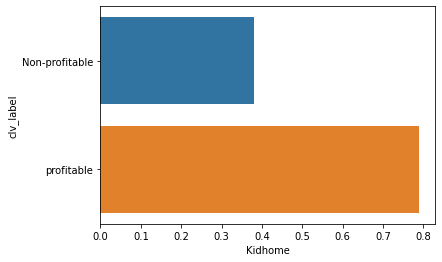

* **Marketing campaign definitely works and it drives business continue marketing**

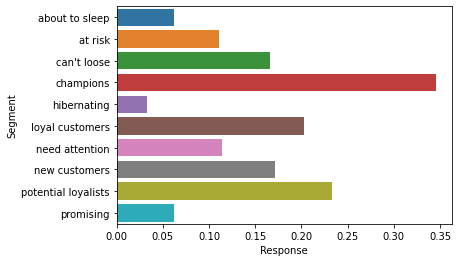